In [1]:
from pyspark.sql import SparkSession
from pysparkling import *
import h2o

ss = SparkSession.builder.getOrCreate()
hc = H2OContext.getOrCreate()

Connecting to H2O server at http://192.168.0.126:54326 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,25 days
H2O_cluster_name:,sparkling-water-dwoodbridge_local-1614447662672
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.32.0.4-1-3.0
 * H2O name: sparkling-water-dwoodbridge_local-1614447662672
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,192.168.0.126,54327)
  ------------------------

  Open H2O Flow in browser: http://192.168.0.126:54326 (CMD + click in Mac OSX)

    


## Create H2OFrames

In [2]:
adult_train_df = ss.read.parquet("../Data/spark-warehouse/adulttrain")
adult_train_h2o = hc.asH2OFrame(adult_train_df, "adult_train")
adult_train_h2o["label"] = adult_train_h2o["label"].asfactor()

adult_valid_df = ss.read.parquet("../Data/spark-warehouse/adultvalid")
adult_valid_h2o = hc.asH2OFrame(adult_valid_df, "adult_valid")
adult_valid_h2o["label"] = adult_valid_h2o["label"].asfactor()

## Apply AutoML

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/automl/autoh2o.html

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.automl.autoh2o.H2OAutoML


### Identify predictors and response

In [3]:
predictors = adult_valid_h2o.names[:]
response = "label"
predictors.remove(response)

In [4]:
from h2o.automl import H2OAutoML
model_automl = H2OAutoML(max_models = 10, seed = 1, nfolds = 5) # seed : Set a seed for reproducibility
model_automl.train(x=predictors,
                   y=response,
                   training_frame=adult_train_h2o,
                   validation_frame=adult_valid_h2o)

AutoML progress: |
09:41:17.459: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


## Leader Board

Reported on cross-validation data.

In [5]:
model_automl.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210227_094117,0.92867,0.29309,0.82912,0.176489,0.300209,0.0901252
StackedEnsemble_BestOfFamily_AutoML_20210227_094117,0.928074,0.293582,0.827962,0.175431,0.30056,0.0903363
GBM_2_AutoML_20210227_094117,0.927759,0.278628,0.827975,0.161469,0.296571,0.0879545
GBM_3_AutoML_20210227_094117,0.927733,0.278726,0.826963,0.174925,0.296892,0.0881451
GBM_4_AutoML_20210227_094117,0.927256,0.279545,0.825669,0.172384,0.297568,0.0885465
GBM_1_AutoML_20210227_094117,0.927177,0.280682,0.824024,0.175272,0.297202,0.0883289
XGBoost_3_AutoML_20210227_094117,0.927139,0.279042,0.824888,0.169656,0.297768,0.088666
GBM_5_AutoML_20210227_094117,0.925736,0.281973,0.822849,0.177506,0.298986,0.0893929
XGBoost_1_AutoML_20210227_094117,0.924176,0.285204,0.817891,0.168654,0.301213,0.0907294
XGBoost_2_AutoML_20210227_094117,0.920809,0.292186,0.811003,0.17639,0.305012,0.0930321


### Model Exploration

In [7]:
h2o.get_model("StackedEnsemble_AllModels_AutoML_20210227_094117")

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20210227_094117

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07562325929111997
RMSE: 0.2749968350565511
LogLoss: 0.2498204917948524
Null degrees of freedom: 10045
Residual degrees of freedom: 10036
Null deviance: 10942.378794648022
Residual deviance: 5019.3933211421745
AIC: 5039.3933211421745
AUC: 0.9507591110021612
AUCPR: 0.8723285759627536
Gini: 0.9015182220043223

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3637179488194282: 


,,0,1,Error,Rate
0,0,7148.0,543.0,0.0706,(543.0/7691.0)
1,1,551.0,1804.0,0.234,(551.0/2355.0)
2,Total,7699.0,2347.0,0.1089,(1094.0/10046.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.363718,0.767333,216.0
1,max f2,0.113653,0.840684,326.0
2,max f0point5,0.661692,0.808160,120.0
3,max accuracy,0.401297,0.893291,203.0
4,max precision,0.966687,1.000000,0.0
5,max recall,0.040708,1.000000,385.0
6,max specificity,0.966687,1.000000,0.0
7,max absolute_mcc,0.401297,0.698382,203.0
8,max min_per_class_accuracy,0.208343,0.870488,278.0
9,max mean_per_class_accuracy,0.164276,0.875321,298.0



Gains/Lift Table: Avg response rate: 23.44 %, avg score: 23.75 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010054,0.966393,4.265817,4.265817,1.000000,0.966796,1.000000,0.966796,0.042887,0.042887,326.581741,326.581741,0.042887
1,2,0.020008,0.965647,4.265817,4.265817,1.000000,0.966047,1.000000,0.966423,0.042463,0.085350,326.581741,326.581741,0.085350
2,3,0.030062,0.964658,4.265817,4.265817,1.000000,0.965193,1.000000,0.966012,0.042887,0.128238,326.581741,326.581741,0.128238
3,4,0.040016,0.962859,4.265817,4.265817,1.000000,0.963797,1.000000,0.965461,0.042463,0.170701,326.581741,326.581741,0.170701
4,5,0.050070,0.960172,4.265817,4.265817,1.000000,0.961698,1.000000,0.964705,0.042887,0.213588,326.581741,326.581741,0.213588
5,6,0.100040,0.857010,4.061874,4.163947,0.952191,0.916413,0.976119,0.940583,0.202972,0.416561,306.187395,316.394714,0.413440
6,7,0.150010,0.712564,3.110138,3.812910,0.729084,0.788444,0.893829,0.889904,0.155414,0.571975,211.013779,281.291045,0.551171
7,8,0.200080,0.491944,2.493341,3.482690,0.584493,0.608152,0.816418,0.819396,0.124841,0.696815,149.334059,248.268974,0.648837
8,9,0.300020,0.211892,1.699529,2.888697,0.398406,0.326182,0.677173,0.655100,0.169851,0.866667,69.952885,188.869719,0.740155
9,10,0.400060,0.092970,0.912588,2.394547,0.213930,0.140781,0.561334,0.526488,0.091295,0.957962,-8.741220,139.454692,0.728733




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.09294568596684032
RMSE: 0.3048699492682746
LogLoss: 0.3006602689510358
Null degrees of freedom: 9827
Residual degrees of freedom: 9818
Null deviance: 10872.215747616709
Residual deviance: 5909.778246501559
AIC: 5929.778246501559
AUC: 0.925717436712807
AUCPR: 0.8268009775443546
Gini: 0.8514348734256141

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17837779263903775: 


,,0,1,Error,Rate
0,0,6301.0,1151.0,0.1545,(1151.0/7452.0)
1,1,391.0,1985.0,0.1646,(391.0/2376.0)
2,Total,6692.0,3136.0,0.1569,(1542.0/9828.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.178378,0.720247,290.0
1,max f2,0.101154,0.806211,332.0
2,max f0point5,0.746767,0.766616,91.0
3,max accuracy,0.553066,0.871998,152.0
4,max precision,0.966767,1.000000,0.0
5,max recall,0.034898,1.000000,399.0
6,max specificity,0.966767,1.000000,0.0
7,max absolute_mcc,0.415793,0.634358,193.0
8,max min_per_class_accuracy,0.170032,0.838835,294.0
9,max mean_per_class_accuracy,0.138918,0.843386,310.0



Gains/Lift Table: Avg response rate: 24.18 %, avg score: 23.92 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010073,0.966466,4.136364,4.136364,1.000000,0.966796,1.000000,0.966796,0.041667,0.041667,313.636364,313.636364,0.041667
1,2,0.020045,0.965510,4.136364,4.136364,1.000000,0.966009,1.000000,0.966404,0.041246,0.082912,313.636364,313.636364,0.082912
2,3,0.030016,0.964420,4.136364,4.136364,1.000000,0.965020,1.000000,0.965945,0.041246,0.124158,313.636364,313.636364,0.124158
3,4,0.040090,0.962312,4.136364,4.136364,1.000000,0.963465,1.000000,0.965322,0.041667,0.165825,313.636364,313.636364,0.165825
4,5,0.050061,0.959136,4.136364,4.136364,1.000000,0.960968,1.000000,0.964454,0.041246,0.207071,313.636364,313.636364,0.207071
5,6,0.100020,0.859429,3.656175,3.896513,0.883910,0.914855,0.942014,0.939680,0.182660,0.389731,265.617478,289.651346,0.382082
6,7,0.150081,0.713242,2.816426,3.536240,0.680894,0.795685,0.854915,0.891649,0.140993,0.530724,181.642646,253.624037,0.502007
7,8,0.200041,0.495478,2.341974,3.237977,0.566191,0.609474,0.782808,0.821177,0.117003,0.647727,134.197371,223.797743,0.590427
8,9,0.300061,0.211047,1.544299,2.673418,0.373347,0.328919,0.646321,0.657091,0.154461,0.802189,54.429853,167.341780,0.662226
9,10,0.399980,0.097876,1.082531,2.276000,0.261711,0.143693,0.550242,0.528839,0.108165,0.910354,8.253101,127.599963,0.673102




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09012515400211658
RMSE: 0.3002085175375885
LogLoss: 0.29309022182032973
Null degrees of freedom: 39013
Residual degrees of freedom: 39004
Null deviance: 42879.76830540764
Residual deviance: 22869.24382819669
AIC: 22889.24382819669
AUC: 0.9286700660673414
AUCPR: 0.8291202433237957
Gini: 0.8573401321346827

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3483039202311423: 


,,0,1,Error,Rate
0,0,27181.0,2522.0,0.0849,(2522.0/29703.0)
1,1,2496.0,6815.0,0.2681,(2496.0/9311.0)
2,Total,29677.0,9337.0,0.1286,(5018.0/39014.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.348304,0.730909,223.0
1,max f2,0.092457,0.808662,339.0
2,max f0point5,0.658956,0.764605,122.0
3,max accuracy,0.500726,0.874814,175.0
4,max precision,0.967142,1.000000,0.0
5,max recall,0.034553,1.000000,399.0
6,max specificity,0.967142,1.000000,0.0
7,max absolute_mcc,0.348304,0.646404,223.0
8,max min_per_class_accuracy,0.182884,0.844915,291.0
9,max mean_per_class_accuracy,0.154394,0.846002,306.0



Gains/Lift Table: Avg response rate: 23.87 %, avg score: 23.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010022,0.966459,4.190098,4.190098,1.000000,0.966944,1.000000,0.966944,0.041993,0.041993,319.009773,319.009773,0.041993
1,2,0.020018,0.965533,4.190098,4.190098,1.000000,0.966023,1.000000,0.966484,0.041886,0.083879,319.009773,319.009773,0.083879
2,3,0.030015,0.964126,4.179354,4.186520,0.997436,0.964861,0.999146,0.965943,0.041779,0.125658,317.935389,318.651951,0.125624
3,4,0.040011,0.962045,4.168610,4.182045,0.994872,0.963147,0.998078,0.965245,0.041671,0.167329,316.861005,318.204502,0.167228
4,5,0.050008,0.958064,4.157866,4.177212,0.992308,0.960313,0.996925,0.964259,0.041564,0.208893,315.786621,317.721173,0.208691
5,6,0.100015,0.853885,3.691839,3.934525,0.881087,0.913125,0.939006,0.938692,0.184620,0.393513,269.183906,293.452540,0.385500
6,7,0.149997,0.712803,2.825630,3.565020,0.674359,0.790318,0.850820,0.889251,0.141231,0.534744,182.563001,256.501993,0.505353
7,8,0.200005,0.494815,2.437602,3.283129,0.581753,0.607456,0.783545,0.818793,0.121899,0.656643,143.760171,228.312925,0.599780
8,9,0.299995,0.211632,1.619756,2.728719,0.386568,0.329991,0.651230,0.655873,0.161959,0.818602,61.975580,172.871881,0.681174
9,10,0.400010,0.096452,0.993296,2.294807,0.237058,0.145223,0.547674,0.528194,0.099345,0.917947,-0.670415,129.480747,0.680294


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20210227_094117,0.92867,0.29309,0.82912,0.176489,0.300209,0.0901252,14853,0.016486
StackedEnsemble_BestOfFamily_AutoML_20210227_094117,0.928074,0.293582,0.827962,0.175431,0.30056,0.0903363,11793,0.006523
GBM_2_AutoML_20210227_094117,0.927759,0.278628,0.827975,0.161469,0.296571,0.0879545,2721,0.005483
GBM_3_AutoML_20210227_094117,0.927733,0.278726,0.826963,0.174925,0.296892,0.0881451,2644,0.005607
GBM_4_AutoML_20210227_094117,0.927256,0.279545,0.825669,0.172384,0.297568,0.0885465,2842,0.00533
GBM_1_AutoML_20210227_094117,0.927177,0.280682,0.824024,0.175272,0.297202,0.0883289,2534,0.005556
XGBoost_3_AutoML_20210227_094117,0.927139,0.279042,0.824888,0.169656,0.297768,0.088666,2232,0.001524
GBM_5_AutoML_20210227_094117,0.925736,0.281973,0.822849,0.177506,0.298986,0.0893929,3391,0.005845
XGBoost_1_AutoML_20210227_094117,0.924176,0.285204,0.817891,0.168654,0.301213,0.0907294,2527,0.001699
XGBoost_2_AutoML_20210227_094117,0.920809,0.292186,0.811003,0.17639,0.305012,0.0930321,2845,0.002074


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210227_094117


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3637179488194282: 


,,0,1,Error,Rate
0,0,7148.0,543.0,0.0706,(543.0/7691.0)
1,1,551.0,1804.0,0.234,(551.0/2355.0)
2,Total,7699.0,2347.0,0.1089,(1094.0/10046.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

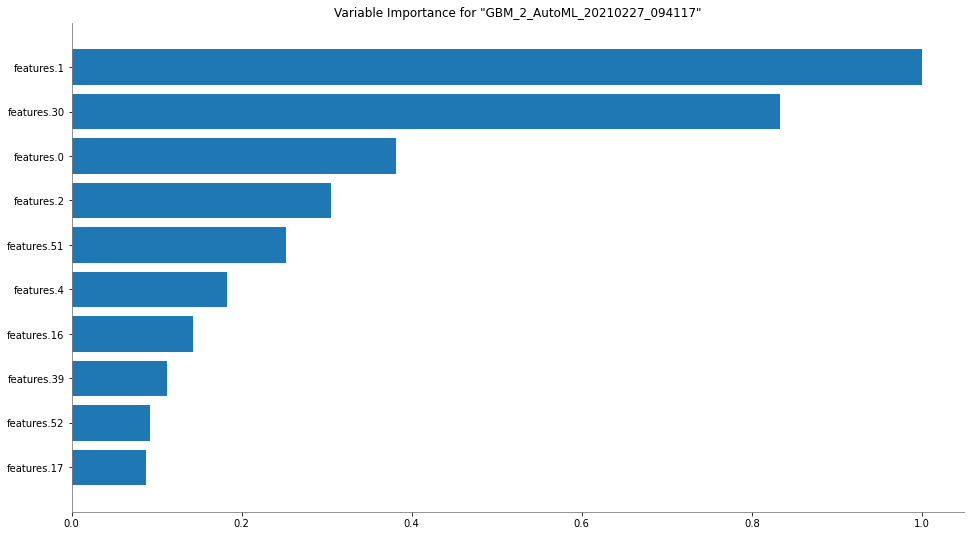

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

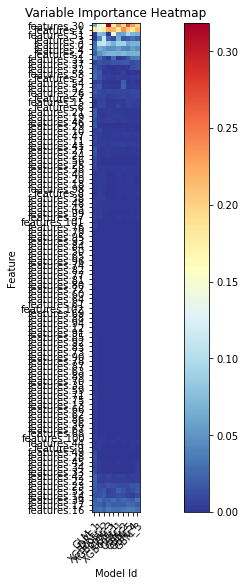

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

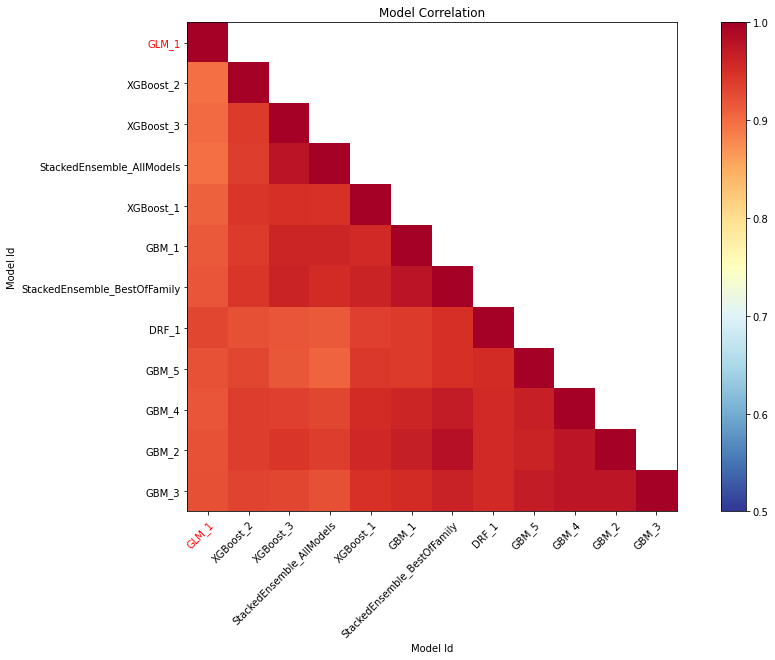

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

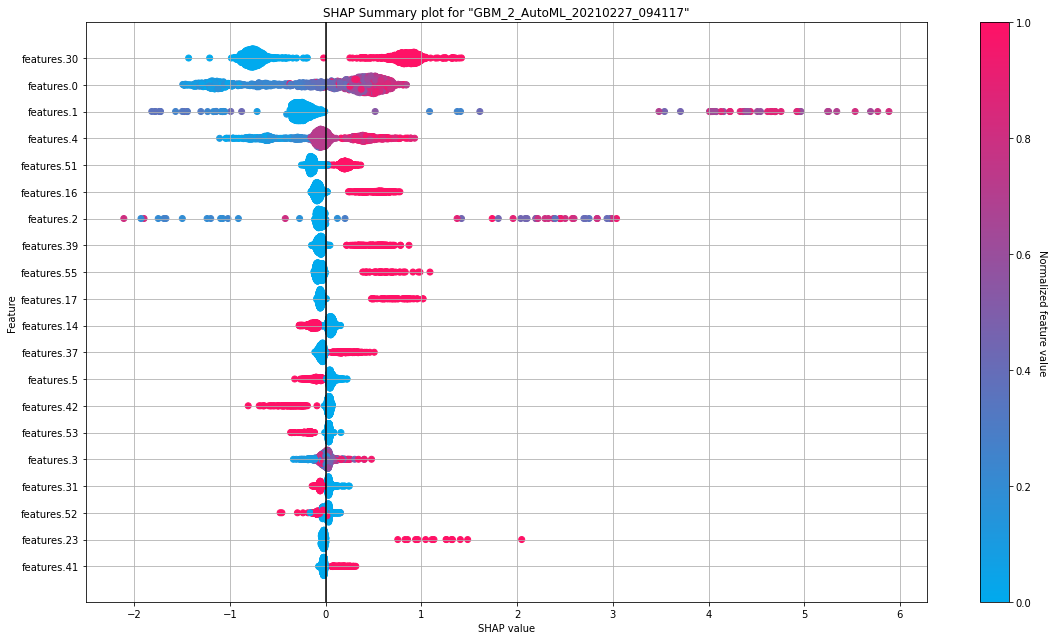

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

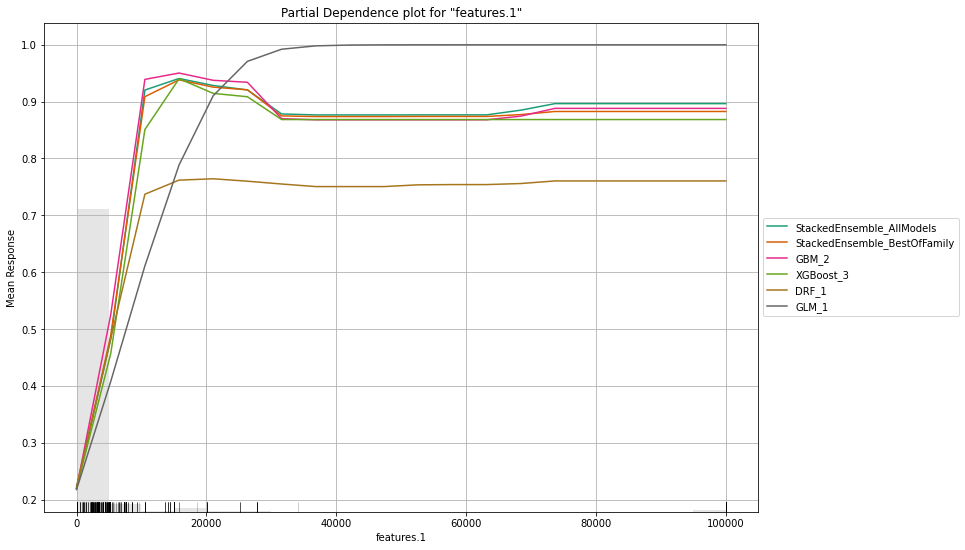

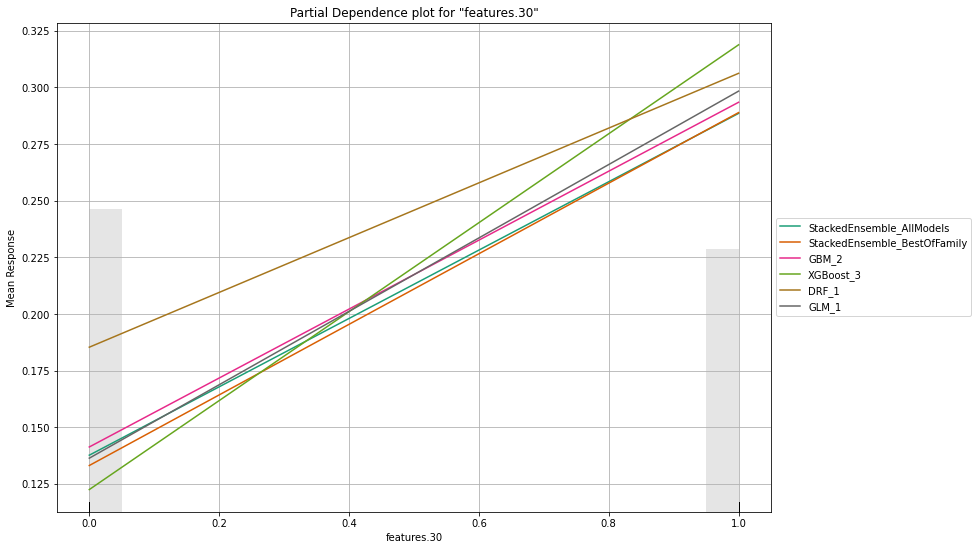

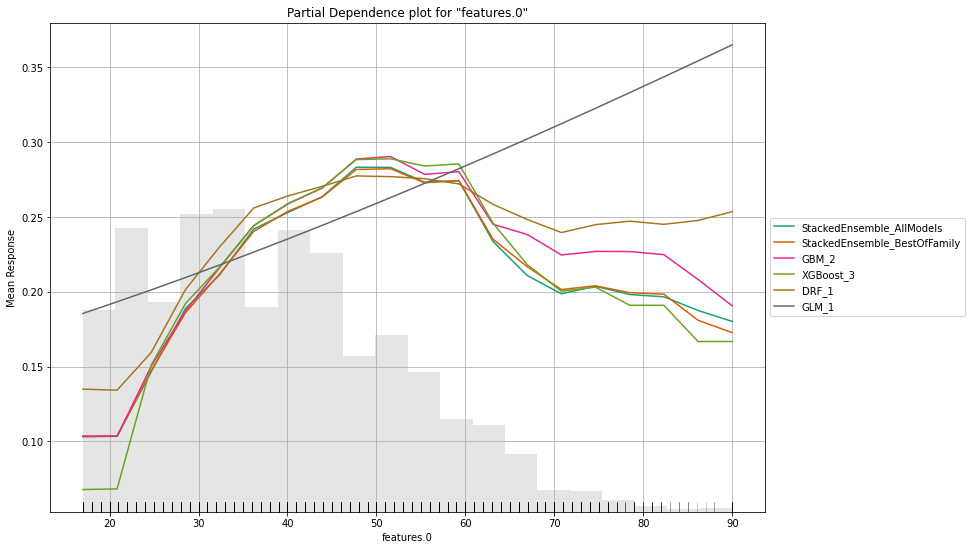

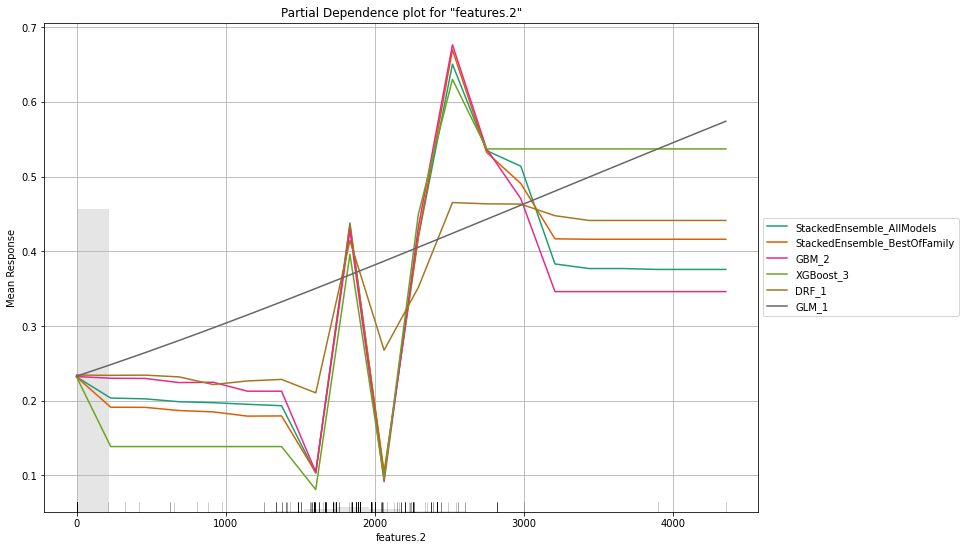

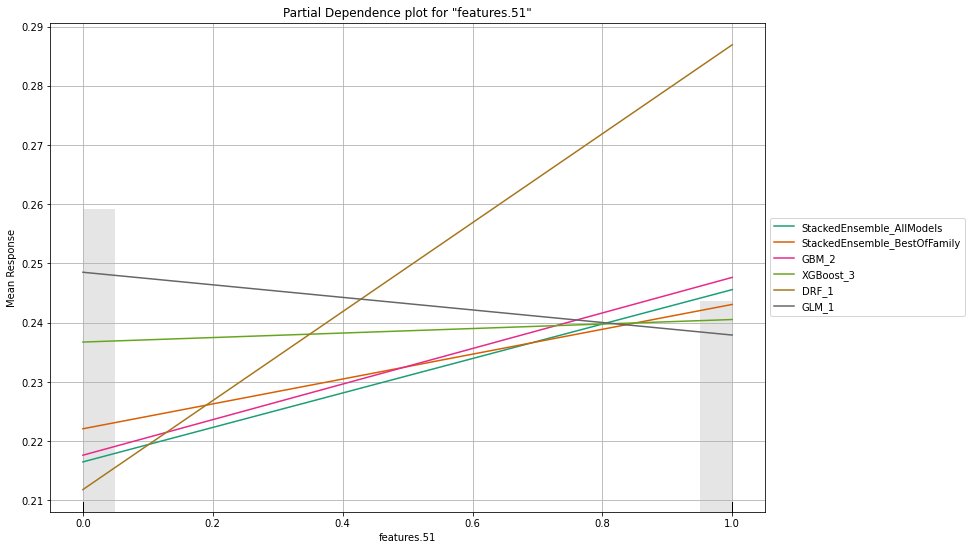

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20210227_094117,0.92867,0.29309,0.82912,0.176489,0.300209,0.0901252,14853,0.016486
StackedEnsemble_BestOfFamily_AutoML_20210227_094117,0.928074,0.293582,0.827962,0.175431,0.30056,0.0903363,11793,0.006523
GBM_2_AutoML_20210227_094117,0.927759,0.278628,0.827975,0.161469,0.296571,0.0879545,2721,0.005483
GBM_3_AutoML_20210227_094117,0.927733,0.278726,0.826963,0.174925,0.296892,0.0881451,2644,0.005607
GBM_4_AutoML_20210227_094117,0.927256,0.279545,0.825669,0.172384,0.297568,0.0885465,2842,0.00533
GBM_1_AutoML_20210227_094117,0.927177,0.280682,0.824024,0.175272,0.297202,0.0883289,2534,0.005556
XGBoost_3_AutoML_20210227_094117,0.927139,0.279042,0.824888,0.169656,0.297768,0.088666,2232,0.001524
GBM_5_AutoML_20210227_094117,0.925736,0.281973,0.822849,0.177506,0.298986,0.0893929,3391,0.005845
XGBoost_1_AutoML_20210227_094117,0.924176,0.285204,0.817891,0.168654,0.301213,0.0907294,2527,0.001699
XGBoost_2_AutoML_20210227_094117,0.920809,0.292186,0.811003,0.17639,0.305012,0.0930321,2845,0.002074


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210227_094117


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3637179488194282: 


,,0,1,Error,Rate
0,0,7148.0,543.0,0.0706,(543.0/7691.0)
1,1,551.0,1804.0,0.234,(551.0/2355.0)
2,Total,7699.0,2347.0,0.1089,(1094.0/10046.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

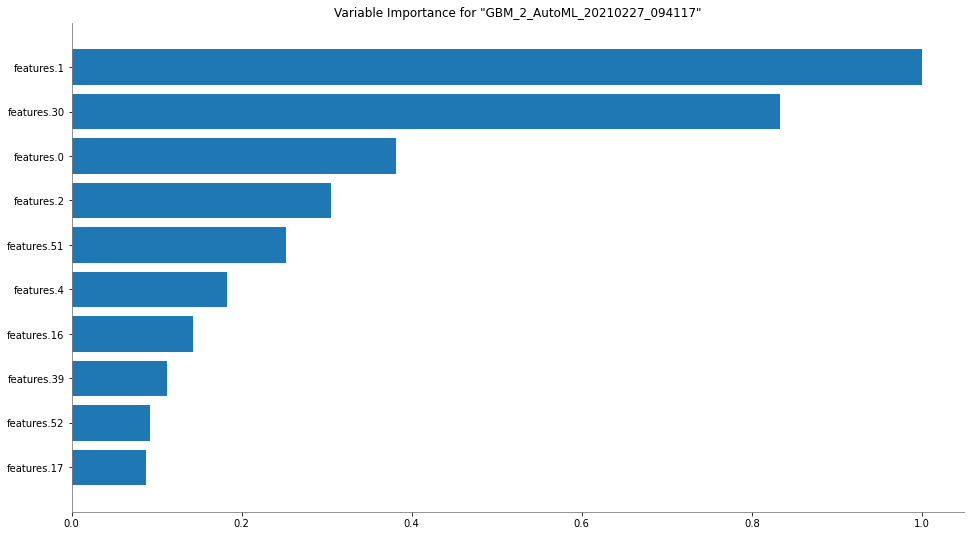

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

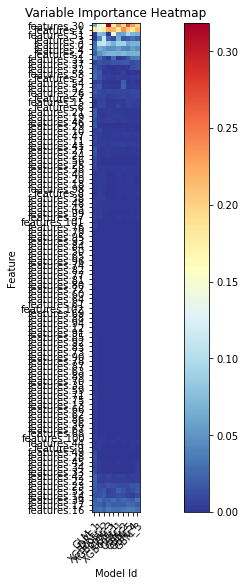

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

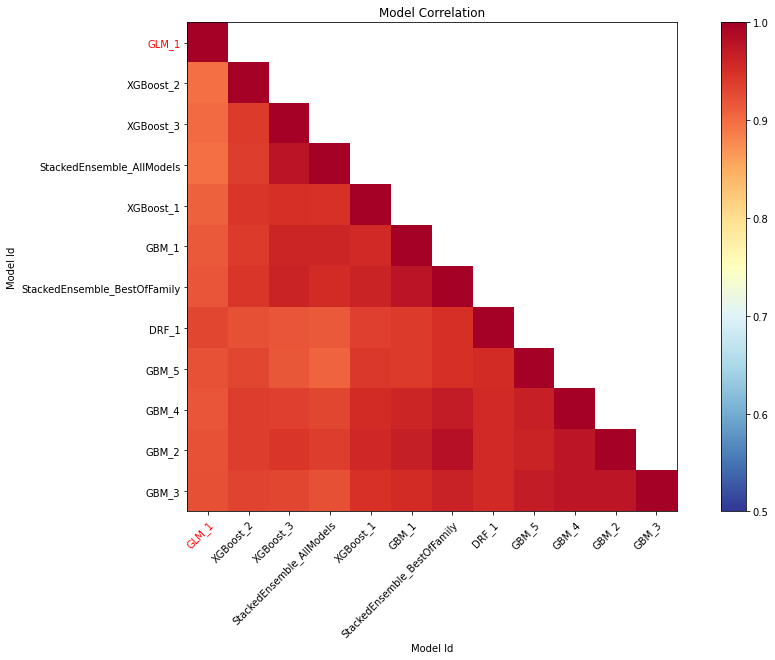

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

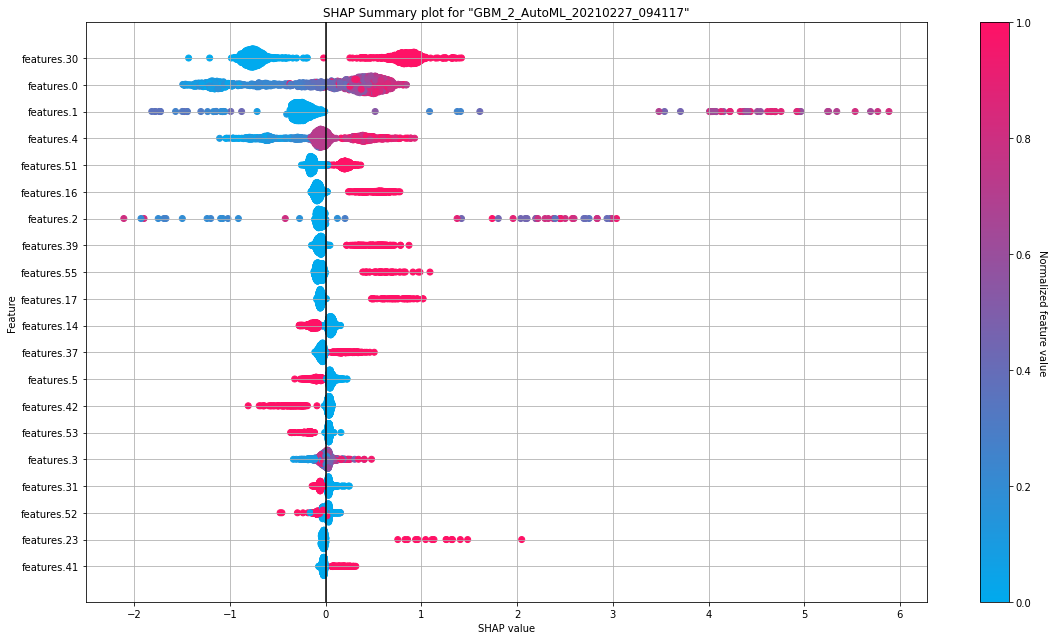

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

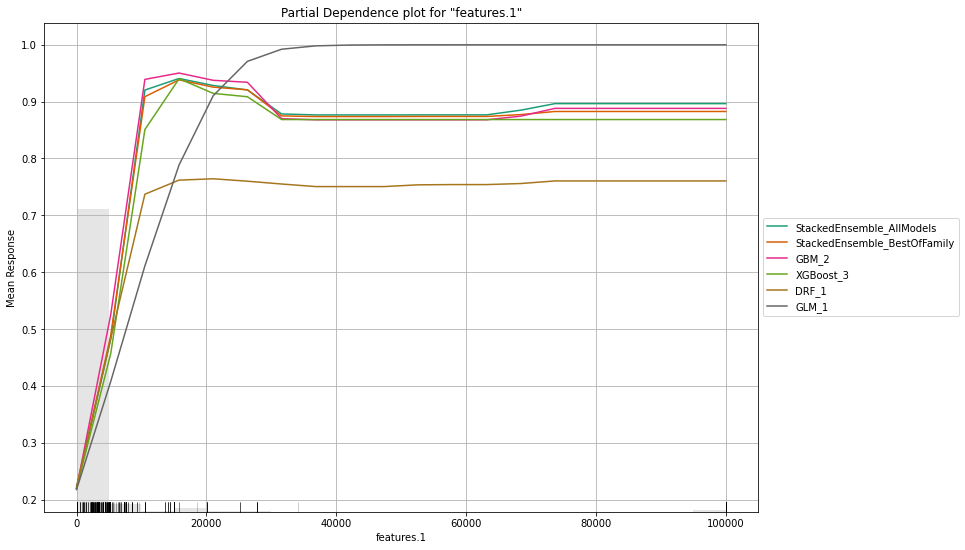

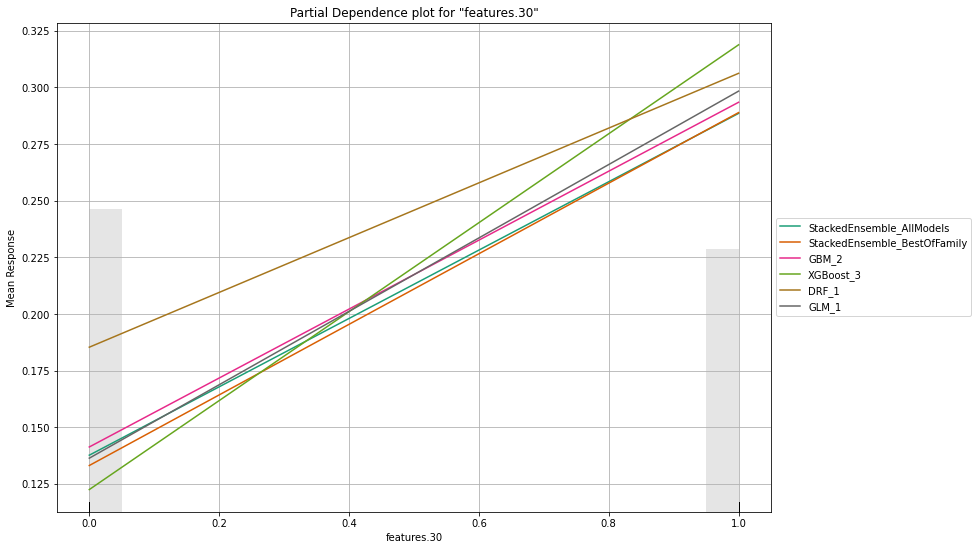

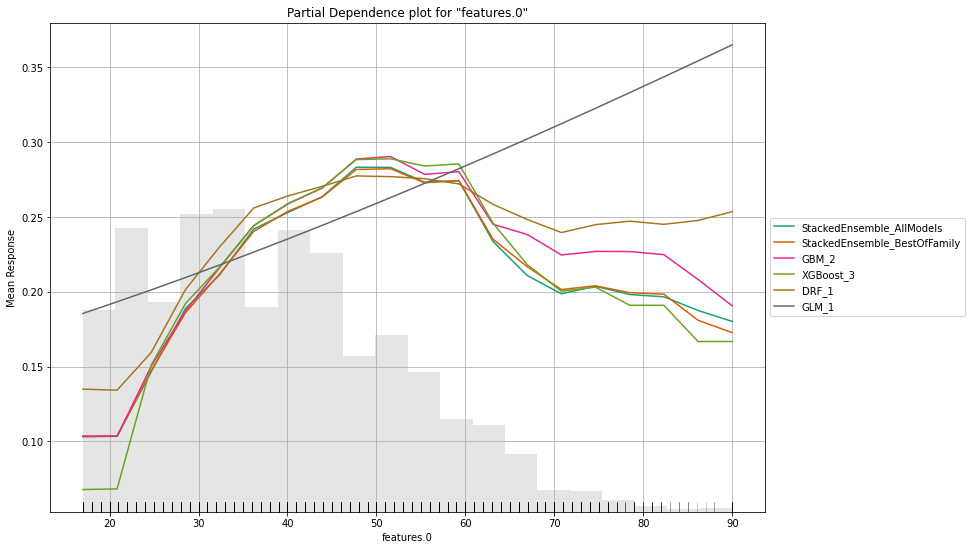

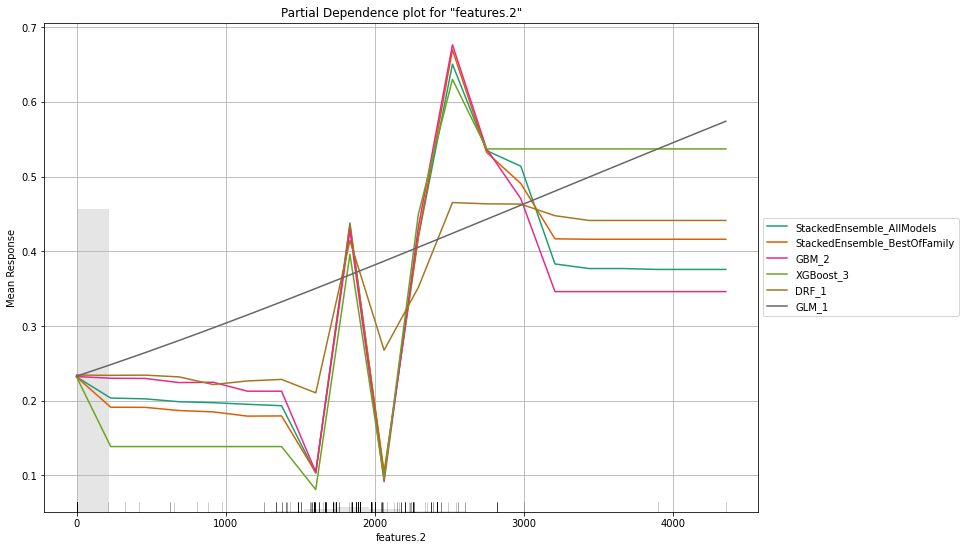

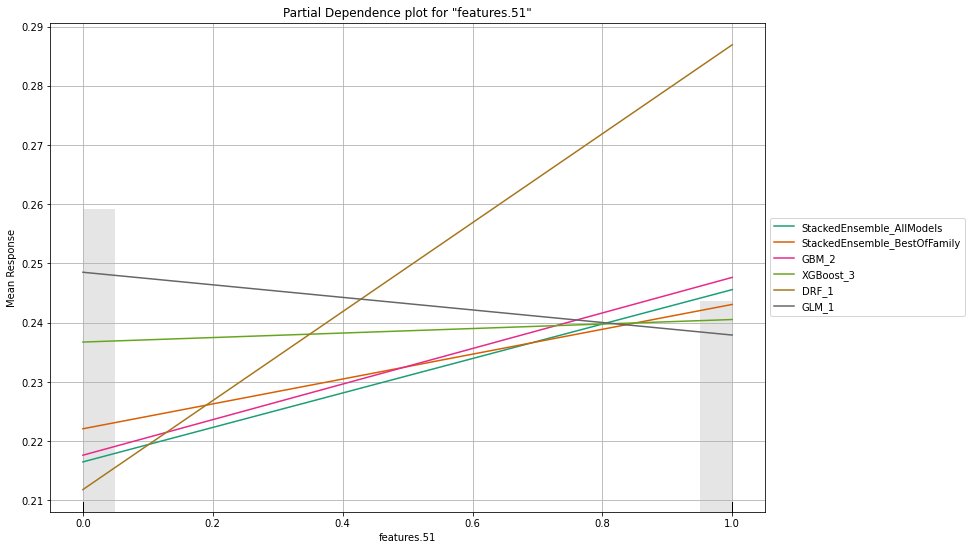

In [8]:
model_automl.explain(adult_valid_h2o)

In [9]:
predictions = model_automl.predict(adult_valid_h2o)
predictions

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p0,p1
1,0.0351233,0.964877
1,0.0369185,0.963082
0,0.96425,0.0357503
1,0.0385681,0.961432
1,0.246583,0.753417
0,0.965055,0.0349452
0,0.96438,0.0356196
0,0.961965,0.0380354
0,0.964707,0.0352935
1,0.229944,0.770056


In [10]:
ss.stop()